### 앞부분은 테스트용

In [13]:
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [3]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

In [4]:
import matplotlib.pyplot as plt
import platform

# 1. 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    # Windows: 맑은 고딕
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    # Mac: AppleGothic
    plt.rc('font', family='AppleGothic')
else:
    # Linux (Colab 등): 나눔고딕
    plt.rc('font', family='NanumGothic')

# 2. 그래프에서 마이너스 기호(-)가 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# # 설정 확인을 위한 테스트 코드
# plt.title("한글 출력 테스트")
# plt.plot([-1, 0, 1], [-1, 0, 1])
# plt.show()

In [5]:
# Feature Engineering
def engineer_features(all_data):
    # 할인율 10% 초과 여부 컬럼 생성 (Binary Feature) 10% 이하면 0, 10% 초과면 1
    all_data['is_high_discount'] = (all_data['Discount_offered'] > 10).astype(int)

    # 무게 구간별 분류 (Binning) 분석 결과 2kg~4kg가 핵심이므로, 이를 포함한 3개 구간으로 나눔.
    bins = [0, 2000, 4000, all_data['Weight_in_gms'].max()]
    labels = ['Low_Weight', 'Mid_Weight', 'High_Weight']
    all_data['weight_bin'] = pd.cut(all_data['Weight_in_gms'], bins=bins, labels=labels)

In [6]:
# 1. 합치기 (나중에 나누기 위해 행 개수 저장)
n_train = len(train_df)
all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# 추가로 컬럼 생성
engineer_features(all_data)

# 원-핫 인코딩 (Mode_of_Shipment) 
# all_data = pd.get_dummies(all_data, columns=['Mode_of_Shipment', 'weight_bin'])
all_data = pd.get_dummies(all_data, columns=['Mode_of_Shipment', 'weight_bin'])

# 라벨 인코딩
le = LabelEncoder()
for col in all_data.select_dtypes(include=['object']).columns:
    all_data[col] = le.fit_transform(all_data[col].astype(str))

# 불필요한 컬럼 삭제 
all_data = all_data.drop(['ID', 'Customer_care_calls', 'Customer_rating','Gender', 'Warehouse_block'], axis=1)

# 타겟 컬럼을 맨 뒤로 재배치
target_col = 'Reached.on.Time_Y.N'
cols = [c for c in all_data.columns if c != target_col] + [target_col]
all_data = all_data[cols]
# 원래 변수명 그대로 나누기 (기존 코드)
train_df = all_data.iloc[:n_train, :].copy()
test_df = all_data.iloc[n_train:, :].copy()

print(f"컬럼 개수 일치 확인: {train_df.shape[1]} == {test_df.shape[1]}")

컬럼 개수 일치 확인: 13 == 13


In [7]:
# 스케일링
numeric_cols = ['Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [8]:
# 1. 학습용 데이터
X_train = train_df.drop('Reached.on.Time_Y.N', axis=1)
y_train = train_df['Reached.on.Time_Y.N']

# 2. 테스트용 데이터
X_test = test_df.drop('Reached.on.Time_Y.N', axis=1)
y_test = test_df['Reached.on.Time_Y.N']

xgb_tuned = XGBClassifier(
                            n_estimators=1000,
                            learning_rate=0.05,
                            max_depth=6,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            random_state=42,
                            eval_metric='logloss',
                            verbosity=0
                        )

models = {
    'XGBoost': xgb_tuned
}

# 모델 학습 및 평가 결과를 저장할 딕셔너리
performance = {}

print("모델별 학습 및 평가 시작...")

for name, model in models.items():
    # 1. 모델 학습
    model.fit(X_train, y_train)
    
    # 2. 예측
    pred = model.predict(X_test)

    # ROC-AUC를 위해 '1(지연)'일 확률을 가져옴
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test)[:, 1]
    else: # SVC 등 확률 제공 안 하는 설정일 경우 대비
        prob = model.decision_function(X_test)
    
    # 3. 평가지표 계산
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, prob) # AUC 추가
    
    # 4. 결과 저장
    performance[name] = {'acc': acc, 'f1': f1, 'auc': auc}
    print(f"완료: {name}")

# ROC-AUC 기준으로 정렬
sorted_performance = sorted(performance.items(), key=lambda x: x[1]['auc'], reverse=True)

# 5. 결과 출력
print("\n" + "="*55)
print(f"{'Model Name':<20} | {'Accuracy':<8} | {'F1':<8} | {'AUC':<8}")
print("-" * 55)

for name, scores in sorted_performance:
    print(f"{name:<20} | {scores['acc']:.4f}   | {scores['f1']:.4f}   | {scores['auc']:.4f}")
print("="*55)

모델별 학습 및 평가 시작...
완료: XGBoost

Model Name           | Accuracy | F1       | AUC     
-------------------------------------------------------
XGBoost              | 0.6614   | 0.7021   | 0.7446


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. 모델별 파라미터 그리드 설정
# GBM: 현재 1위 모델이므로 가장 정교하게 튜닝
# param_gbm = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 4, 5]
# }

use_cpu = round(os.cpu_count()*(2/3))
use_cpu

# XGBoost: F1-Score의 강점을 AUC로 전환하기 위한 튜닝
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    # 'use_label_encoder': [False],
    'eval_metric': ['logloss']
}

# SVC: 확률 기반 Voting을 위해 probability=True 필수
# 파이프라인을 사용해 스케일링과 튜닝을 동시에 진행
param_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

# 2. GridSearchCV 실행 (각각) 
# print("GBM 튜닝 중...")
# grid_gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), param_gbm, cv=5, scoring='roc_auc', n_jobs=use_cpu)
# grid_gbm.fit(X_train, y_train)

print("XGBoost 튜닝 중...")
grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_xgb, cv=5, scoring='roc_auc', n_jobs=use_cpu)
grid_xgb.fit(X_train, y_train)

print("SVC 튜닝 중...")
svc_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=42))])
grid_svc = GridSearchCV(svc_pipe, param_svc, cv=5, scoring='roc_auc', n_jobs=use_cpu)
grid_svc.fit(X_train, y_train)

# 3. 최적의 모델들로 Soft Voting 앙상블 결성
# best_gbm = grid_gbm.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_svc = grid_svc.best_estimator_

ensemble_model = VotingClassifier(
    # estimators=[('gbm', best_gbm), ('xgb', best_xgb), ('svc', best_svc)],
    estimators=[('xgb', best_xgb), ('svc', best_svc)],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)

# 앙상블 모델의 확률값 예측 (soft voting이므로 predict_proba 사용)
ensemble_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# 최종 AUC 계산
final_auc = roc_auc_score(y_test, ensemble_pred_proba)

print("\n--- 튜닝 및 앙상블 완료 ---")
# print(f"Best GBM AUC: {grid_gbm.best_score_:.4f}")
print(f"Best XGB AUC: {grid_xgb.best_score_:.4f}")
print(f"Best SVC AUC: {grid_svc.best_score_:.4f}")
print(f"최종 앙상블 모델 AUC: {final_auc:.4f}")

XGBoost 튜닝 중...
SVC 튜닝 중...

--- 튜닝 및 앙상블 완료 ---
Best XGB AUC: 0.7421
Best SVC AUC: 0.7410
최종 앙상블 모델 AUC: 0.7560


========================================================================

## 1. 모델 성능 비교 및 분석

#### 1-1 피처 중요도

C:\Users\user\AppData\Local\Temp\ipykernel_26648\2882899219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='magma') # 컬러 팔레트


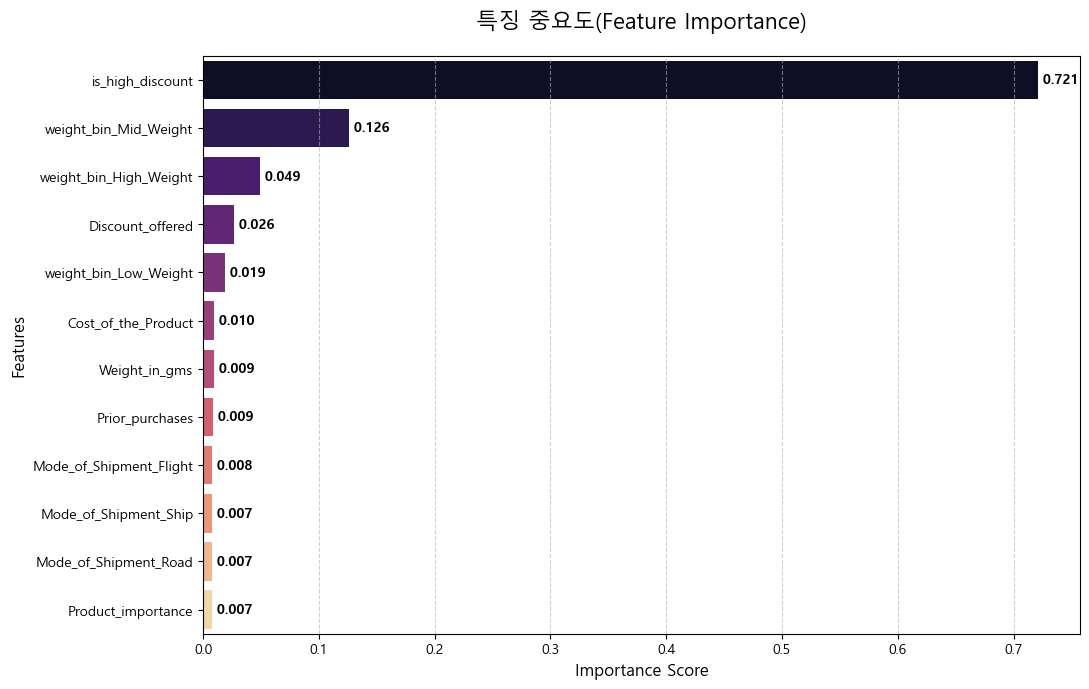

In [9]:

final_model = models['XGBoost']

# 1. 데이터를 DataFrame으로 정리 (정렬을 위해)
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False) # 중요도 순 정렬

# 2. 그래프 그리기
plt.figure(figsize=(11, 7))
# plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='magma') # 컬러 팔레트

# 3. 그래프 디테일 추가
plt.title('특징 중요도(Feature Importance)', fontsize=16, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6) # 가이드 라인 추가

# 각 막대 끝에 수치 표시 (선택 사항)
for i, v in enumerate(feature_imp['Importance']):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

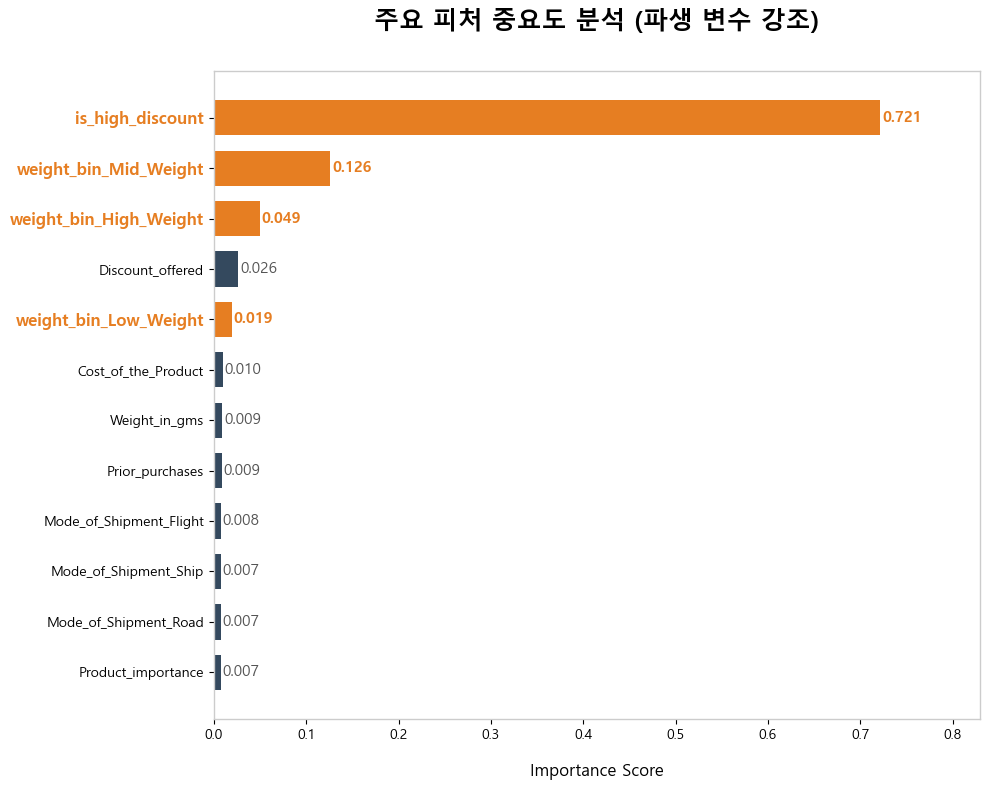

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 데이터 정리
final_model = models['XGBoost'] 
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=True)

# 2. 강조 테마 설정
highlight_keys = ['is_high_discount', 'weight_bin']
highlight_color = '#E67E22'  
default_color = '#34495E'    

# 3. 그래프 생성
fig, ax = plt.subplots(figsize=(10, 8))

colors = [highlight_color if any(k in f for k in highlight_keys) else default_color 
          for f in feature_importance['Feature']]
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], 
               color=colors, height=0.7)

#  4. 테두리(윤곽선) 전체 가시화 수정 부분
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#CCCCCC')
    ax.spines[spine].set_linewidth(1)

# 5. 가독성 개선
ax.set_xlim(0, feature_importance['Importance'].max() * 1.15)

for i, val in enumerate(feature_importance['Importance']):
    feat_name = feature_importance['Feature'].iloc[i]
    is_target = any(k in feat_name for k in highlight_keys)
    
    ax.text(val + 0.002, i, f'{val:.3f}', va='center', ha='left',
            fontsize=11, fontweight='bold' if is_target else 'normal',
            color=highlight_color if is_target else '#555555')
    
    if is_target:
        ax.get_yticklabels()[i].set_color(highlight_color)
        ax.get_yticklabels()[i].set_fontweight('bold')
        ax.get_yticklabels()[i].set_fontsize(12)

plt.title('주요 피처 중요도 분석 (파생 변수 강조)', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Importance Score', fontsize=12, labelpad=15)

plt.tight_layout()
plt.show()

위 그래프에 대한 해석 작성 필요 (최종 모델 그래프 보고 내용 작성하기)
- EDA에서 발견한 무게와 할인율이 모델의 의사결정에 결정적 기여
- 원본 데이터 변수들보다 생성한 파생 변수가 더 높은 중요도를 가짐

피처 중요도 그래프가 지나치게 불균형하게 나오는 경우 모델이 특정 변수에 지나치게 의존하는 것처럼 보일 수 있음

-> 실제 데이터 내에서 지연과 할인율의 상관관계가 그만큼 강력하다는 것을 의미한다고 변론 가능

기업 입장이라면 실제 운송에 영향을 주는 데이터('기상환경', '물류터미널 내 사고' 등)의 추가 수집 필요성 제시

### 1-2. Accuracy, F1, ROR_AOC 지표 성능 비교

In [14]:
# 현재 임의로 개별 모델들 vs 앙상블 지표 성능 비교하는 코드이나
# 앙상블모델 튜닝 전 vs 앙상블모델 튜닝 후 비교로 변경하거나 튜닝 후 모델 단독으로 수정 예정
# Accuracy, AUC, F1 사용 (F1 제거 예정)

# 1. 비교를 위한 데이터 수집 리스트
performance_list = []

# 2. 개별 모델(models 딕셔너리) 성능 수집
for name, model in models.items():
    y_pred = model.predict(X_test)
    # SVC 등 확률 제공 안 하는 모델이 있을 수 있으므로 처리
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = model.decision_function(X_test) # 확률 대신 결정 함수값 사용
        
    performance_list.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

# 3. 앙상블 모델 성능 수집
y_pred_ens = ensemble_model.predict(X_test)
y_proba_ens = ensemble_model.predict_proba(X_test)[:, 1]

performance_list.append({
    'Model': 'Ensemble(Voting)',
    'Accuracy': accuracy_score(y_test, y_pred_ens),
    'F1-Score': f1_score(y_test, y_pred_ens),
    'AUC': roc_auc_score(y_test, y_proba_ens)
})

# 4. DataFrame 생성 및 출력
df_perf = pd.DataFrame(performance_list).set_index('Model')
print("--- [Model Performance Comparison] ---")
print(df_perf.round(4))


--- [Model Performance Comparison] ---
                  Accuracy  F1-Score     AUC
Model                                       
XGBoost             0.6614    0.7021  0.7446
Ensemble(Voting)    0.6668    0.6639  0.7560


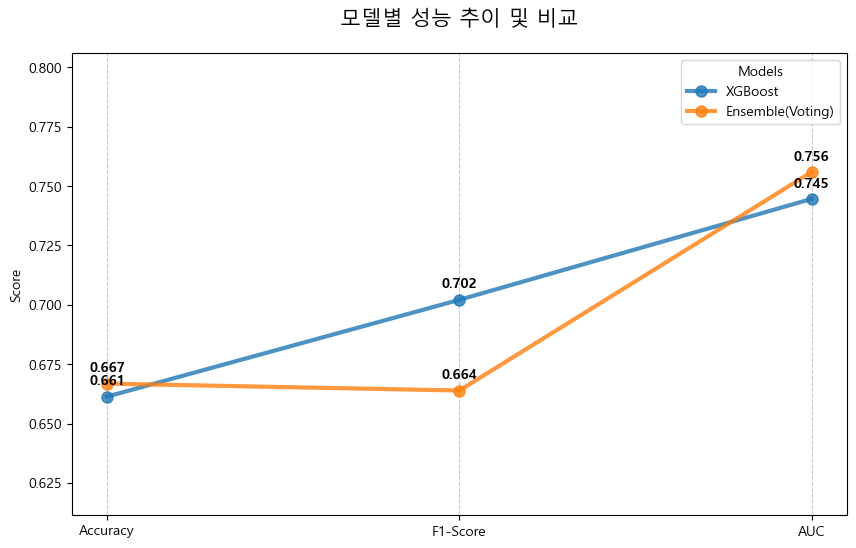

In [15]:
plt.figure(figsize=(10, 6))

# 데이터 전치(Transpose) 하여 지표를 X축으로 배치
df_plt = df_perf.T

for col in df_plt.columns:
    plt.plot(df_plt.index, df_plt[col], marker='o', markersize=8, label=col, linewidth=3, alpha=0.8)
    # 각 점 옆에 수치 표시
    for i, val in enumerate(df_plt[col]):
        plt.text(i, val + 0.005, f'{val:.3f}', ha='center', fontweight='bold')

plt.ylim(df_perf.min().min() - 0.05, df_perf.max().max() + 0.05)
plt.title('모델별 성능 추이 및 비교', size=15, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Models", loc='upper right')
plt.ylabel('Score')
plt.show()

AUC는 클래스 비율에 영향을 받지 않는 지표로, 우리 모델이 단순 확률 통계에 의존하지 않고 변수들 간의 비선형적 관계를 학습했음을 입증

평가 지표에 희민님이 작성하신 gap 정보를 추가하여 신뢰도를 뒷받침하는 결과로 제시 가능.

auc가 성능을 입증하는 지표라면 gap는 실무환경에서의 모델 신뢰성 입증. (gap이 작을수록 데이터의 변화에도 성능이 잘 유지됨)

==Gap ==
- 모델이 학습한 데이터(Train)와 처음 보는 데이터(Test) 사이의 성적 차이
- 모델이 **'패턴을 학습(Learning)'**했는지, 아니면 **'데이터를 암기(Memorization)'**했는지를 판가름하는 척도

========

만약 Train과 Test의 AUC Gap이 0.05 이하면 모델이 단순 암기가 아닌 데이터의 일반적인 패턴을 잘 학습했음을 시사하며, 실무 적용 시에도 안정적인 성능을 기대할 수 있습니다.

cf) CatBoost는 자체적으로 과적합 방지 기능이 뛰어나서 이 Gap이 다른 모델(Decision Tree 등)보다 작게 나오는 편

### 모델간 비교 시각화

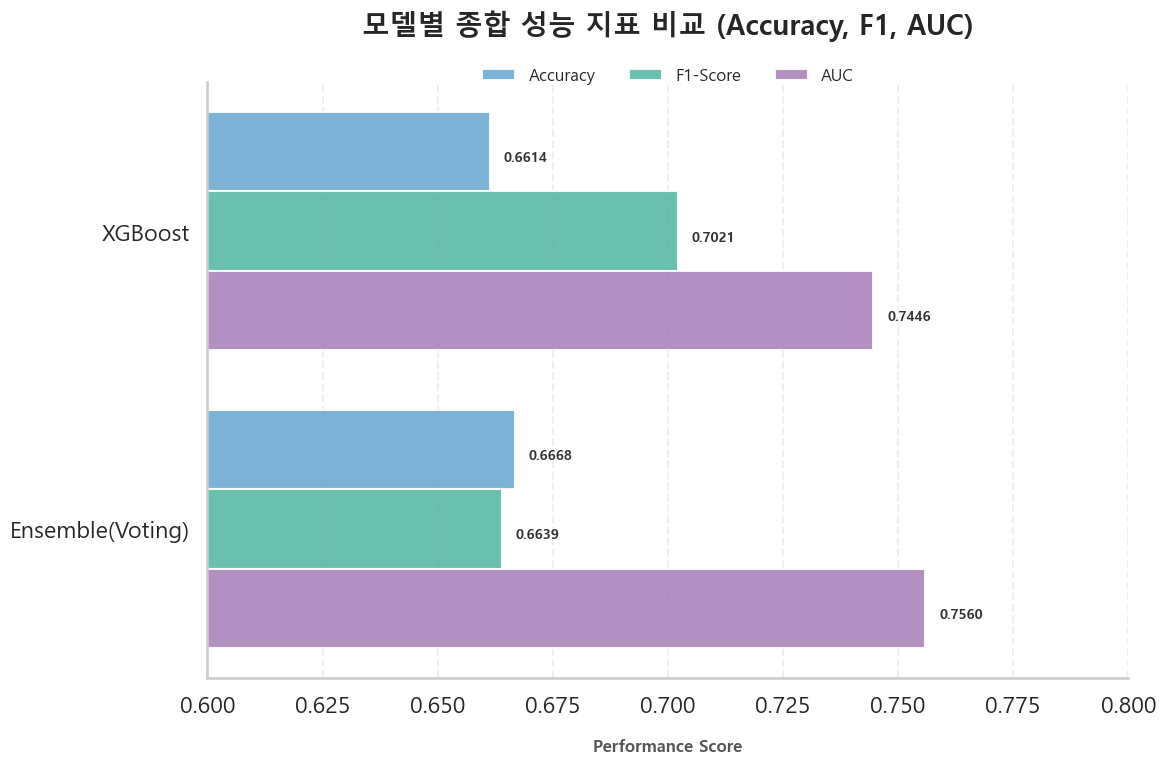

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import platform

# 1. 한글 폰트 및 그래프 기본 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False 
# sns.set_style("white")

# 2. 데이터 재구성 (Tidy Data 형태로 변환)
# df_perf는 [Model, Accuracy, F1-Score, AUC] 형태이므로 시각화를 위해 melt가 필요합니다.
df_plot = df_perf.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

# 3. 그래프 생성
plt.figure(figsize=(12, 8), facecolor='white')

# 세련된 컬러 조합 (이미지 로고 등에서 자주 쓰이는 Deep & Soft 컬러)
palette = {"Accuracy": "#5DADE2", "F1-Score": "#48C9B0", "AUC": "#AF7AC5"}

# 수평 그룹 막대 그래프
ax = sns.barplot(data=df_plot, y='Model', x='Score', hue='Metric', 
                 palette=palette, alpha=0.9, edgecolor='white')

# 4. 차트 디자인 고도화
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')

# 지표 눈금 범위 설정 (모델 간 미세 성능 차이를 보여주기 위해 0.6부터 시작)
plt.xlim(0.6, 0.8) 

# 5. 수치 라벨링 (막대 끝에 값 표시)
for p in ax.patches:
    width = p.get_width()
    if width > 0: # 0이 아닌 경우에만 표시
        ax.text(width + 0.003, p.get_y() + p.get_height()/2 + 0.02,
                f'{width:.4f}', va='center', fontsize=10, fontweight='bold', color='#333333')

# 6. 제목, 레이블, 범례 최적화
plt.title('모델별 종합 성능 지표 비교 (Accuracy, F1, AUC)', fontsize=20, fontweight='bold', pad=35)
plt.xlabel('Performance Score', fontsize=12, labelpad=15, fontweight='bold', color='#555555')
plt.ylabel('', fontsize=12)

# 범례를 차트 상단에 깔끔하게 배치
plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.05), 
           ncol=3, frameon=False, fontsize=12)

# 가로 눈금선 추가 (가독성 향상)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

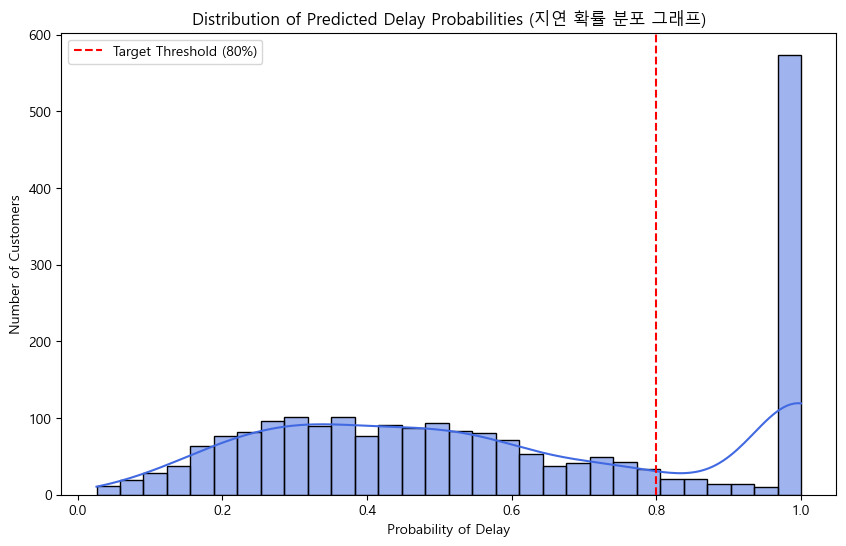

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 앞서 구한 prob 변수(XGBoost의 지연 확률) 활용
plt.figure(figsize=(10, 6))
sns.histplot(prob, bins=30, kde=True, color='royalblue')

# 확률 80% 지점에 가이드라인 표시
plt.axvline(x=0.8, color='red', linestyle='--', label='Target Threshold (80%)')

plt.title('Distribution of Predicted Delay Probabilities (지연 확률 분포 그래프)')
plt.xlabel('Probability of Delay')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()

분류 모델의 작동 원리
- Step 1 (회귀 단계): 데이터들을 보고 "이 샘플이 1에 가까운지 0에 가까운지" 연속적인 점수를 매깁니다. (이게 우리가 본 0.8, 0.3 같은 확률입니다.)
- Step 2 (판정 단계): 그 점수가 특정 기준(보통 0.5)을 넘으면 "1이다!", 안 넘으면 "0이다!"라고 이름표를 붙입니다

-> 거의 모든 현대적 분류 모델은 내부적으로 '회귀'를 한 뒤에 '분류'

predict : 지연(1) , 아니다(0) 라는 이분법적 결론 반환 <br>
predict_proba : 지연되지 않을 확률과 지연될 확률을 각각 소수점으로 반환 (예시) [0.2, 0.8] -> 20퍼센트의 확률로 정시도착, 80퍼센트의 확률로 지연 <br>

In [44]:
Train['ID'].head()

0    1
1    2
2    3
3    4
4    5
Name: ID, dtype: int64

In [ ]:
# 1. 분석용 데이터프레임 생성
# X_test의 인덱스를 유지하여 어떤 고객인지 식별 가능하게 함
action_df = pd.DataFrame({
    'Customer_ID': X_test.index, # 실제 데이터의 ID 컬럼이 있다면 그걸 쓰세요 -> rawData에는 있음. 필요하면 피처엔지니어링시 삭제하지 말 것.
    'Delay_Probability': prob
})

# 2. 확률 80% 이상인 고객 필터링 (Targeting)
target_customers = action_df[action_df['Delay_Probability'] >= 0.8].copy()

# 3. 가상의 문자 발송 메시지 생성
target_customers['SMS_Message'] = "[알림] 고객님, 배송이 조금 지연될 가능성이 있어 미리 안내드립니다. 죄송한 마음을 담아 쿠폰을 보내드립니다."

# 결과 확인
print(f"--- [문자 발송 대상자 분석] ---")
print(f"총 발송 대상: {len(target_customers)}명")
print("-" * 35)
print(target_customers[['Customer_ID', 'Delay_Probability', 'SMS_Message']].head())

# (선택) 이 리스트를 엑셀로 저장해서 물류팀에 전달한다면?
# target_customers.to_csv('sms_target_list.csv', index=False)

--- [문자 발송 대상자 분석] ---
총 발송 대상: 655명
-----------------------------------
    Customer_ID  Delay_Probability  \
0          8799           0.999852   
9          8808           0.999720   
13         8812           0.991600   
22         8821           0.999872   
24         8823           0.922255   

                                          SMS_Message  
0   [알림] 고객님, 배송이 조금 지연될 가능성이 있어 미리 안내드립니다. 죄송한 마음...  
9   [알림] 고객님, 배송이 조금 지연될 가능성이 있어 미리 안내드립니다. 죄송한 마음...  
13  [알림] 고객님, 배송이 조금 지연될 가능성이 있어 미리 안내드립니다. 죄송한 마음...  
22  [알림] 고객님, 배송이 조금 지연될 가능성이 있어 미리 안내드립니다. 죄송한 마음...  
24  [알림] 고객님, 배송이 조금 지연될 가능성이 있어 미리 안내드립니다. 죄송한 마음...  


[모델 평가(잘 된 부분과 한계점)]

1) 모델링 잘 된 부분 (내가 돌렸던 모델에 대한 예시임. 수정필요) 
- 비선형성 극복 : 선형 모델로만 모델링했으면 놓칠 수 있었던 특정 무게 구간(2~4kg)의 계단식 지연율 변화를 
			피처엔지니어링과 비선형 트리 모델로 시너지효과

2) 한계점
- 데이터의 불균형성 : 할인율과 무게 구간이라는 파생 변수로 지연의 상당 부분을 설명했지만, <br>
사실 배송은 '물류 터미널 환경(내 사고)'나 '기상 악화'  외부 요인이 작용했을 가능성이 있음. 데이터 부족.  
기업 입장에서 차후 배송 지연 예측 모델을 위한 추가적 데이터 수집의 필요성을 입증.
					-> 추가되면 좋을 데이터 컬럼들 고려.

7. 서비스개발 (기업보다는 고객에게 취할 수 있는 다른 액션을 좀 더 생각해볼 필요가 있음)
- 지연 선제 대응 시스템 : 구매후 배송시작시 구매자에게 배송지연 알림 발송 (배송지연 확률 80%이상에게만 문자 발송)
- 관리자 대시보드 : 실시간으로 지연 위험 물량을 모니터링
- 물류 최적화 필요성 : 특정 무게/할인 조합의 물량을 우선 처리하도록하는 데이터로 활용

배송시간/도착일자 데이터 없이도 배송지연확률은 구할 수 있음. <br>
확률데이터 활용 : 고객에게 몇프로의 확률로 배송지연 대상이라고 고지하는 것 외에 추가적 액션을 취할 수 있음.

이를 바탕으로 배송지연에 대한 대응을 두가지로 분류<br>
1. 선제적 대응<br>
배송지연 확률 80퍼센트가 넘는 제품을 구매한 고객들에게는 <br>
배송지연 알림 문자 발송과 함께 할인쿠폰/무료배송쿠폰 제공 -> 보상을 미리 지급해 불만 상쇄, 재구매 유도<br>
기업의 쿠폰 제공비용은 발생할 수 있으나 고객이탈 방지비용 측면에서는 경제적<br>

2. 사후 보장<br>
앞서 선제대응한 고객을 제외하고 실제로 배송지연된 고객들도 쿠폰 제공
